In [1]:
import os
from _io import open
import numpy as np
import csv
import pandas as pd
from pandas import DataFrame
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.grid_search import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import MinMaxScaler

D:\Softwares\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Softwares\envs\tensorflow-gpu\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def recall_scorer(est,X,y):
    return np.mean(recall_score(y, est.predict(X),
                                average='weighted'))

In [3]:
# label_name = 'class'
# f = open('test_data/german_categorical.csv')
#label_name = 'income-per-year'
label_name = 'Class'
#f = open('test_data/adult.csv')
f = open('DI_old_sorelle/media/RicciDataMod.csv')

identifiers = ['Position', 'Race']

data = [line for line in csv.reader(f)]
headers = data.pop(0)

df = DataFrame(data, columns=headers, dtype='float64')

for col in identifiers:
    del df[col]
#print(df)
#print(pd.get_dummies(df['duration']))
#print(df.dtypes)
#print(df.select_dtypes(include=['float64']))
class_labels = {k: v for v, k in enumerate(df[label_name].unique())}
#print(class_labels)
#labels = [1 if l == 'good' else 0 for l in df['class']]
labels = [class_labels[l] for l in df[label_name]]
del df[label_name]
#df
for col in df.columns:
    if df.dtypes[col] == object:
#        print(col)
        dum = pd.get_dummies(df[col], prefix=col+'_')
        del df[col]
        df = pd.concat([df, dum], axis=1)
#    else:
#        print(col, len(df[col].unique()))
df
#print(labels)
#df.values
train_data, test_data, train_labels, test_labels = train_test_split(df, labels, test_size=0.33, random_state=100)
# clf = SVC(class_weight='balanced')
clf = GridSearchCV(make_pipeline(MinMaxScaler(), SVC(class_weight='balanced')),
                       param_grid={
                           'svc__C' : np.logspace(-3,3,num=13)
                       },
                       scoring=recall_scorer)
clf.fit(train_data, train_labels)
pred = clf.predict(test_data)
#print(confusion_matrix(test_labels, pred))
c = confusion_matrix(test_labels, pred)
ber = 0
for r in range(c.shape[0]):
    num = 0
    den = 0
    for col in range(c.shape[1]):
        if r == col:
            den += c[r][col]
        else:
            num += c[r][col]
            den += c[r][col]
    #print(num, den)
    ber += (num/den)
original_ber = 1 - (ber / c.shape[0])
original_accuracy = clf.score(test_data, test_labels)

rec = recall_scorer(clf, test_data, test_labels)
#print(1 - rec)
#original_ber = 1 - rec

D:\Softwares\envs\tensorflow-gpu\lib\site-packages\sklearn\grid_search.py:438: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


In [4]:
#%%timeit
X = []
Y = []
B = []
# directory = 'results/german/age'
#directory = 'results/adult/race'
directory = 'results/sorelle'
for fileName in os.listdir(directory):
    #f = open('results/german/age/german_repaired_1.0.csv')
    #f = open('test_data/german_categorical.csv')
    f = open(os.path.join(directory, fileName))
#    print(fileName)
    data = [line for line in csv.reader(f)]
    headers = data.pop(0)

    df = DataFrame(data, columns=headers, dtype='float64')
    #print(pd.get_dummies(df['duration']))
    #print(df.dtypes)
    #print(df.select_dtypes(include=['float64']))
    labels = [class_labels[l] for l in df[label_name]]
    del df[label_name]
    for col in df.columns:
        if df.dtypes[col] == object:
    #        print(col)
            dum = pd.get_dummies(df[col], prefix=col+'_')
            del df[col]
            df = pd.concat([df, dum], axis=1)
    #    else:
    #        print(col, len(df[col].unique()))
    #df
    #print(labels)
    #df.values
    train_data, test_data, train_labels, test_labels = train_test_split(df, labels, test_size=0.33, random_state=100)
    clf = GridSearchCV(make_pipeline(MinMaxScaler(), SVC(class_weight='balanced')),
                       param_grid={
                           'svc__C' : np.logspace(-3,3,num=13)
                       },
                       scoring=recall_scorer)
    clf.fit(train_data, train_labels)
    pred = clf.predict(test_data)
    c = confusion_matrix(test_labels, pred)
    ber = 0
    for r in range(c.shape[0]):
        num = 0
        den = 0
        for col in range(c.shape[1]):
            if r == col:
                den += c[r][col]
            else:
                num += c[r][col]
                den += c[r][col]
        #print(num, den)
        ber += (num/den)
    ber = ber / c.shape[0]
    #print(ber, c)
    #ber = recall_scorer(clf, test_data, test_labels)
    B.append(1 - ber)
    X.append(fileName.split('_')[-1].split('.csv')[0])
    #Y.append(clf.score(test_data, test_labels))
    Y.append(ber)
#    results[fileName.split('_')[-1].split('.csv')[0]] = clf.score(test_data, test_labels)
#print(X, Y, B)
    

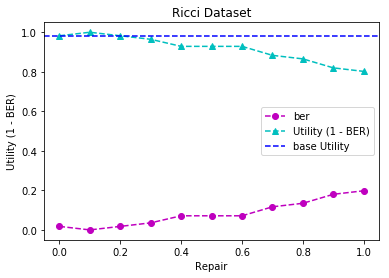

In [5]:
plt.plot(X, Y, 'mo--', label='ber')
plt.plot(X, B, 'c^--', label='Utility (1 - BER)')
#plt.axhline(y=original_accuracy, color='b', linestyle='-', label='base accuracy')
plt.axhline(y=original_ber, color='b', linestyle='--', label='base Utility')
plt.legend()
plt.title('Ricci Dataset')
plt.ylabel('Utility (1 - BER)')
plt.xlabel('Repair')
plt.show()

In [6]:
protected = ''